### **Clustering implementation**

In this section, the previously selected clustering methods will be implemented.

#### **Scaling the data**

First, we will prepare the data for applying the selected clustering methods. Since different features may have different scales (e.g., `n_clicks` and `monto_compras`), it is crucial to scale the data to ensure all features are on a similar scale. This can be achieved using a scaler from scikit-learn.

| **Variable**         | **StandardScaler**                                                                             | **MinMaxScaler**                                                                                  | **MaxAbsScaler**                                                                               | **RobustScaler**                                                                                   | **Normalizer**                                                                           | **PowerTransformer**                                                                         | **QuantileTransformer**                                                                      | **Binarizer**                                                                | **FunctionTransformer**                                                              |
|-----------------------|-----------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------|------------------------------------------------------------------------------------------|
| `n_clicks`           | 🟢 Suitable for normalizing dispersion and bringing data to a similar scale, useful for K-means. | 🟡 Useful for adjusting values to a [0, 1] range, but it might lose the relationship with data dispersion.   | 🟡 Acceptable, but not ideal for columns with high dispersion and outliers.                     | 🟡 Works in the presence of outliers, though not the best choice for a skewed distribution.          | 🔴 Not applicable because magnitude and dispersion are important for behavior analysis.  | 🟡 Acceptable for normalizing data with skewed distributions, but not ideal.                   | 🟡 Useful for correcting skewed distribution, but may distort information.                        | 🔴 Not suitable as it is a continuous variable that should maintain its scale.         | 🟡 Can be helpful for applying a specific transformation or adjusting values.         |
| `n_visitas`          | 🟢 Suitable for normalizing dispersion and maintaining scale, useful for techniques like K-means. | 🟡 Useful for adjusting range to [0, 1], but may lose important dispersion relationships for behavior.        | 🟡 Acceptable, but not ideal in the presence of outliers and high dispersion.                    | 🟡 Works well for columns with outliers, though not the best choice if there’s significant asymmetry. | 🔴 Not applicable as general dispersion is important for the analysis.                     | 🟡 Suitable for reducing bias but may not be very effective for asymmetric distributions.      | 🟡 Useful for making the distribution more uniform, but should be analyzed carefully.           | 🔴 Not applicable as it doesn’t fit a continuous variable with relevant magnitudes.    | 🟡 Can be helpful if adjustments or transformations are required for specific analysis. |
| `monto_compras`      | 🟡 Moderately suitable, as the distribution is not uniform. Standardization can help reduce outlier impact. | 🟡 Useful for scaling values to a defined range, but may not be suitable if values vary significantly.         | 🟡 Acceptable, but may not be the best option with large dispersion or outliers.                  | 🟢 Ideal for handling outliers and skewed distributions. Particularly useful for large differences between customers. | 🟡 Not ideal due to dispersion and outliers but still usable in some contexts.          | 🟢 Suitable for reducing asymmetry, making data more regular and centered.                      | 🟡 Useful for normalizing distribution but must consider the column’s nature.                  | 🟡 Acceptable for range adjustment, but doesn’t necessarily improve the variable.       | 🟡 Acceptable if specific value transformations are required, though not the best option. |
| `monto_descuentos`   | 🟡 Moderately suitable due to dispersion and outliers. Can help reduce the influence of extreme values.  | 🟡 Useful for scaling discount values to a more manageable range, but may lose context about the distribution. | 🟡 Generally acceptable, though not ideal with high dispersion.                                   | 🟢 Ideal for dealing with outliers and skewed distributions, as seen with discounts.                | 🟡 Not ideal due to value nature, though it can still work in certain contexts.          | 🟢 Suitable for reducing asymmetry and making the distribution more regular.                     | 🟡 Useful for transforming distribution but must be evaluated carefully for discounts.         | 🟡 Not ideal for this variable as it doesn’t improve analysis capability.             | 🟡 Acceptable for specific transformation adjustments, though not optimal.              |
| `dias_primera_compra`| 🟢 Suitable for normalizing dispersion in data that is within a relatively defined range.        | 🟡 Useful for adjusting range to [0, 1], but not necessary given the symmetrical distribution.                | 🟡 Acceptable if normalization is desired but doesn’t add much value.                              | 🟢 Useful for mitigating outlier effects, although data doesn’t show a high level of outliers.      | 🟡 Not necessary as data is fairly symmetrical.                                       | 🟡 Suitable for adjusting asymmetry, although not required due to the normal distribution.        | 🟡 Useful for adjusting the distribution but not a significant change.                       | 🔴 Not applicable as binary transformation isn’t useful for this continuous variable.   | 🟡 Useful for specific transformations, though not essential for this case.           |
| `info_perfil`        | 🟢 Suitable for normalizing dispersion and bringing all values to the same scale.               | 🟡 Useful for scaling values to [0, 1], but not always necessary in the context of an ordinal variable.       | 🟡 Acceptable with dispersion, but not ideal for ordinal variables.                               | 🟡 Works generally but not the best choice for a variable with order relationships.                 | 🟡 Not ideal for ordinal variables, as normalization doesn’t make sense in this case.     | 🟢 Suitable for handling asymmetry in the distribution.                                           | 🟡 Useful for transforming the distribution, though it doesn’t improve interpretation much.       | 🔴 Not applicable as it doesn’t suit ordinal variables.                                | 🟡 Useful for specific adjustments but not optimal for an ordinal variable.            |


#### **Scalers and Transformers: Description and Applicability**

| **Scaler**            | **Description**                                                                                   | **Applicability**                                                                                | **Not Applicable**                                                                            |
|------------------------|---------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------|
| **StandardScaler**     | Transforms variables to have a mean of 0 and a standard deviation of 1.                          | ✔ Useful for algorithms sensitive to magnitudes (e.g., K-means, PCA, SVM).                      | ❌ Data with non-normal distributions or extreme outliers.                                    |
| **MinMaxScaler**       | Scales variables to a specified range (default: 0 to 1).                                         | ✔ Useful when variables have different ranges but proportionality matters (e.g., clustering).   | ❌ Data with outliers that distort the scale.                                                 |
| **MaxAbsScaler**       | Scales variables based on the maximum absolute value of each feature while maintaining dispersion. | ✔ Useful for data with dispersed but not extreme distributions (e.g., non-negative input data). | ❌ Data with negative values or highly varying ranges.                                        |
| **RobustScaler**       | Scales using the median and interquartile range (IQR), resistant to outliers.                    | ✔ Suitable for data with extreme values or non-normal distributions.                           | ❌ Data that is already clean or normally distributed.                                        |
| **Normalizer**         | Scales each individual sample vector to unit norm (e.g., L2 norm).                               | ✔ Useful for sparse data or when relationships between magnitudes are irrelevant (e.g., text).  | ❌ Features where absolute magnitudes are important.                                          |
| **PowerTransformer**   | Applies a power transformation (Box-Cox or Yeo-Johnson) to make data more Gaussian-like.          | ✔ Suitable for data with highly skewed or asymmetric distributions.                            | ❌ Data that is already normal or does not require symmetry adjustment.                       |
| **QuantileTransformer**| Transforms data into a uniform or normal distribution based on quantiles.                        | ✔ Useful for normalizing non-Gaussian or highly asymmetric distributions.                      | ❌ Small datasets, as the transformation might be inconsistent.                              |
| **Binarizer**          | Converts features into binary values based on a threshold.                                       | ✔ Useful for categorical variables or boolean data.                                             | ❌ Continuous features that do not need to be dichotomized.                                   |
| **FunctionTransformer**| Allows applying custom functions to features.                                                   | ✔ Useful for transforming data with specific requirements not covered by standard scalers.      | ❌ Standard transformations that already meet the dataset’s needs.                           |


#### **Justification for Scaling Method**

- **`n_clicks`:** StandardScaler The distribution of `n_clicks` is right-skewed, with high dispersion and outliers. StandardScaler is suitable for normalizing the data while preserving key features relevant for techniques like K-means.

- **`n_visitas`:** StandardScaler. Similar to `n_clicks`, this variable exhibits a skewed and dispersed distribution. StandardScaler is appropriate to adjust the distribution to a more uniform scale, facilitating analysis without losing critical information.

- **`monto_compras`:** RobustScaler 
  Due to the presence of two customer groups with significant differences in spending and considerable dispersion in the variable, RobustScaler is the optimal method. It is less sensitive to outliers and preserves relationships within groups.

- **`monto_descuentos`:** RobustScaler. Like `monto_compras`, this variable contains outliers and has a skewed distribution. RobustScaler is appropriate as it effectively handles extreme values without distorting the information about discounts.

- **`dias_primera_compra`:** StandardScaler.  The distribution of `dias_primera_compra` is symmetrical and does not exhibit high variability. StandardScaler is suitable for centering and scaling the data without introducing unnecessary bias.

- **`info_perfil`:** StandardScaler. As an ordinal variable with a symmetrical distribution, StandardScaler is appropriate for normalizing the variable, ensuring its influence on the analysis is proportional while preserving the relationship between values.


In [240]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score

In [241]:
# Loading cleaned dataset
dataset_path = "../data/processed/cleaned_dataset.csv"
df = pd.read_csv(dataset_path)
df = df.drop(columns=["ID","dias_primera_compra", "n_clicks", "info_perfil"])

In [242]:
# Util functions
def scale_minmax(df, column):
    scaler = MinMaxScaler()
    df[column] = scaler.fit_transform(df[[column]])

def visualize_dendrogram(df_scaled, method):
    linked_sample = linkage(df_scaled, method)
    plt.figure(figsize=(10, 7))
    dendrogram(linked_sample, truncate_mode="level", p=5)
    plt.title(f'Dendrogram for Sample of {df_scaled.shape[0]}  Records')
    plt.xlabel('Data Points')
    plt.ylabel('Distance')
    plt.show()

def visualize_clusters(df_scaled, df_objective, column):
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(df_scaled)
    plt.figure(figsize=(6, 4))
    plt.scatter(principal_components[:, 0], principal_components[:, 1], c=df_objective[column], cmap='viridis', s=1)
    plt.title('Cluster Visualization (PCA)')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.colorbar(label='Cluster')
    plt.show

def evaluate_clusters(df_scaled, df_objective, column):
    print(f"Silhouette = {silhouette_score(df_scaled, df_objective[column]):.4f}\n"
          f"Davies-Bouldin = {davies_bouldin_score(df_scaled, df_objective[column]):.4f}")
    visualize_clusters(df_scaled, df_objective, column)

In [243]:
# Scaling variables
df_scaled = df.copy()
minmax = list(df.columns)
for i in minmax:
    scale_minmax(df_scaled, i)

#### **K_Means**
Let's begin with the implementation of K-Means.

##### **Determining the number of clusters (K)**
Once the data is scaled, we need to determine how many clusters we want to use. The optimal number of clusters can be determined using the **Elbow Method** or **Silhouette Score**.

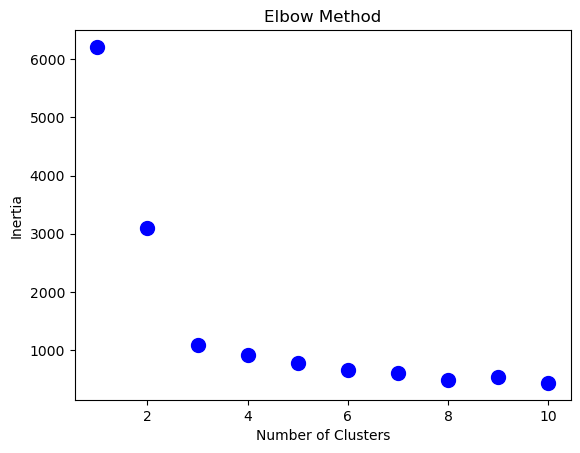

In [244]:
# Elbow method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k).fit(df_scaled.values)
    inertia.append(kmeans.inertia_)

plt.scatter(range(1, 11), inertia, marker="o", s=100, color="blue")
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

##### **Silhouette score**

With the following code:

```python
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k).fit(df_scaled.values)
    score = silhouette_score(df_scaled, kmeans.labels_)
    print(f'K = {k}, Silhouette Score = {score}')
```

The following output was obtained:
```python
K = 2,  Silhouette Score = 0.49008870050951725
K = 3,  Silhouette Score = 0.6382211139494461
K = 4,  Silhouette Score = 0.5520505385997547
K = 5,  Silhouette Score = 0.45557663314555197
K = 6,  Silhouette Score = 0.37186358841203254
K = 7,  Silhouette Score = 0.37952706713582285
K = 8,  Silhouette Score = 0.3694907693066217
K = 9,  Silhouette Score = 0.3641898126623838
K = 10, Silhouette Score = 0.34303524380374645
```

It has been decided to use K-Means with 3 clusters, based on the results obtained from the **Elbow Method** and the **Silhouette Score** analysis, which indicated that 3 clusters provide an appropriate segmentation with good separation between the groups.

In [245]:
df_kmeans = df.copy()
kmeans = KMeans(n_clusters=3).fit(df_scaled.values)
df_kmeans["cluster"] = kmeans.labels_

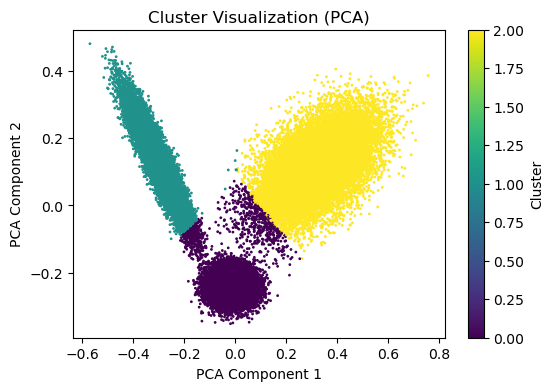

In [246]:
# Visualizing clusters
visualize_clusters(df_scaled, df_kmeans, "cluster")

#### **DBScan**

Now, we will proceed with the implementation of DBScan. DBScan is sensitive to distance, so it is crucial to configure the eps and min_samples parameters correctly. Given the size of the dataset (55,002), we will use a value of 6 for min_samples. The eps value will be determined empirically.

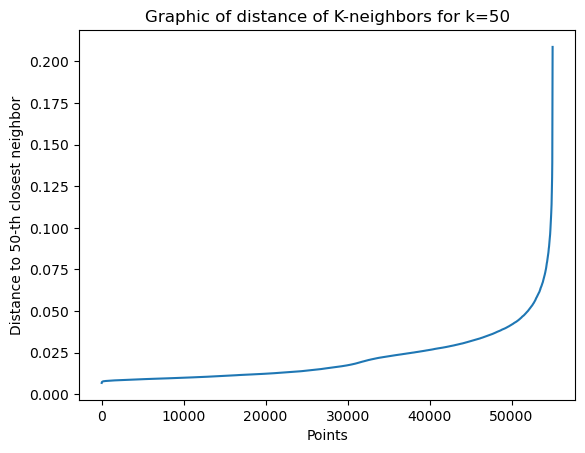

In [247]:
# Determining value of eps

k = 50
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(df_scaled)
distances, indices = neighbors_fit.kneighbors(df_scaled)
distances = np.sort(distances[:, k-1], axis=0)
plt.plot(distances)
plt.title(f'Graphic of distance of K-neighbors for k={k}')
plt.xlabel('Points')
plt.ylabel(f'Distance to {k}-th closest neighbor')
plt.show()

In [248]:
df_dbscan = df.copy()
eps = 0.040
min_samples = 50
dbscan = DBSCAN(eps = eps, min_samples = min_samples)
df_dbscan['cluster'] = dbscan.fit_predict(df_scaled)

In [249]:
# Not cleaned DBSCAN
print("Not cleaned DBSCAN")
print(f"eps={eps}, samples={min_samples}")
print(df_dbscan['cluster'].value_counts())

Not cleaned DBSCAN
eps=0.04, samples=50
cluster
 1    18330
 0    18273
 2    15688
-1     2711
Name: count, dtype: int64


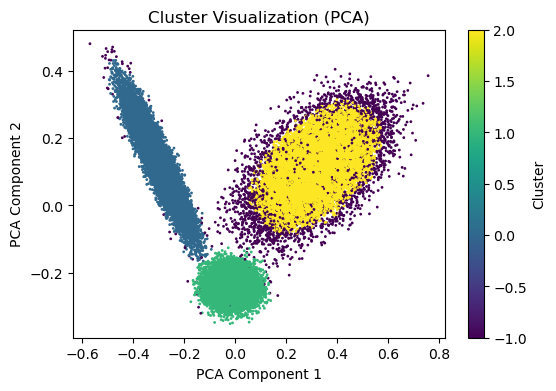

In [250]:
# Visualizing not cleaned clusters
visualize_clusters(df_scaled, df_dbscan, "cluster")

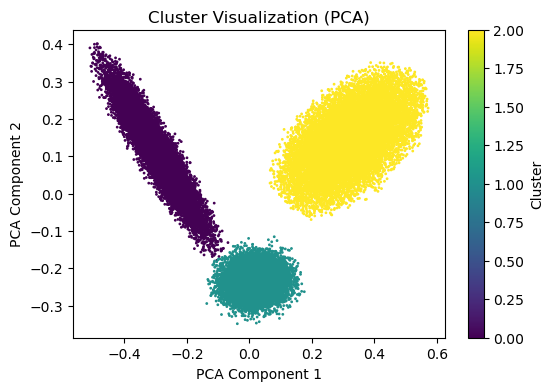

In [251]:
# Cleaning DBSCAN & Visualizing clusters
scaled_db = df_scaled[df_dbscan["cluster"] != -1]
df_dbscan = df_dbscan[df_dbscan["cluster"] != -1]
visualize_clusters(scaled_db, df_dbscan, "cluster")

#### Gaussian Mixture Models

In [252]:
df_gaussi = df.copy()
n_clusters_ = 3  
gaussian = GaussianMixture(
    n_components=n_clusters_, 
    covariance_type='full',  
    init_params='kmeans',    
    max_iter=100, 
    tol=1e-3, 
    random_state=42         
)
df_gaussi["cluster"] = gaussian.fit_predict(df_scaled)

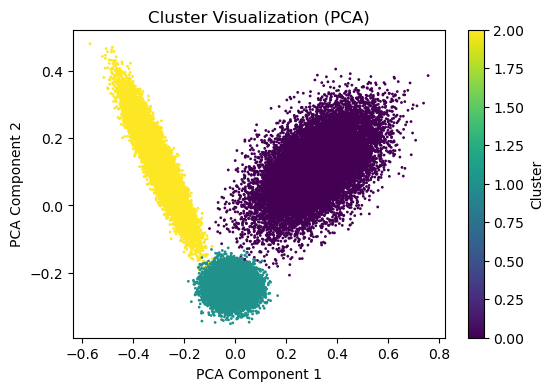

In [253]:
visualize_clusters(df_scaled, df_gaussi, "cluster")

#### Agglomerative Clustering

In [255]:
df_agglom = df.copy()
sample_size = 30000
random_indexes = np.random.choice(df_scaled.shape[0], sample_size, replace=False)
scaled_ag = df_scaled.iloc[random_indexes]
df_agglom = df_agglom.iloc[random_indexes]

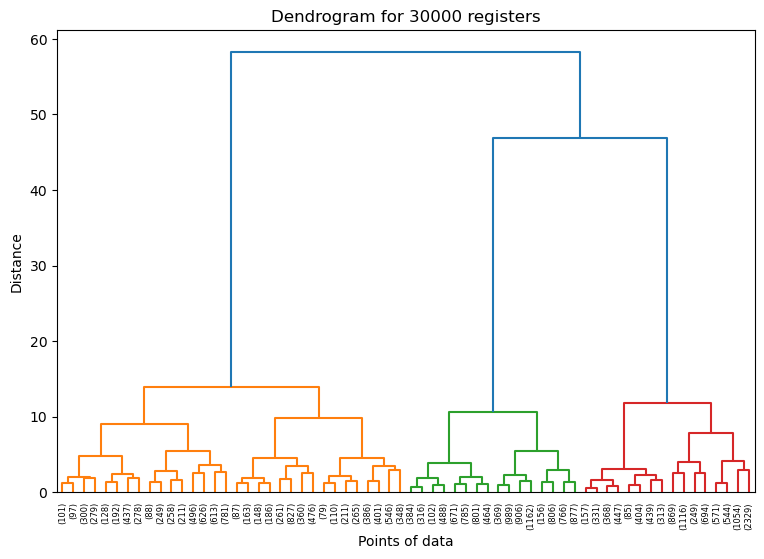

In [256]:
linked_sample = linkage(scaled_ag, method='ward')
plt.figure(figsize=(9, 6))
dendrogram(linked_sample, truncate_mode='level', p=5)
plt.title(f'Dendrogram for {sample_size} registers')
plt.xlabel('Points of data')
plt.ylabel('Distance')
plt.show()

In [257]:
hierarchical = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')
df_agglom["cluster"] = hierarchical.fit_predict(scaled_ag)
print("Primeras etiquetas de cluster asignadas:")
print(df_agglom["cluster"][:10])

Primeras etiquetas de cluster asignadas:
53813    2
10042    1
37044    2
35167    0
2857     1
48059    2
26751    0
921      1
10451    1
25487    0
Name: cluster, dtype: int64


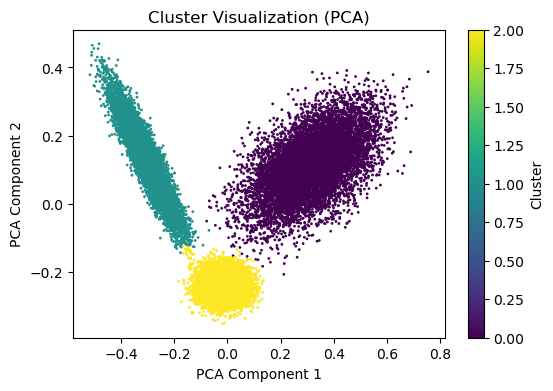

In [258]:
visualize_clusters(scaled_ag, df_agglom, "cluster")

#### **Gaussian Mixture Models (GMM)**
Now, we proceed with Gaussian Mixture Models (GMM) to identify overlapping and elliptical clusters. Unlike hierarchical clustering, GMM processes the entire dataset (55002 records) efficiently, ensuring no patterns are excluded.

Silhouette = 0.6373
Davies-Bouldin = 0.5026


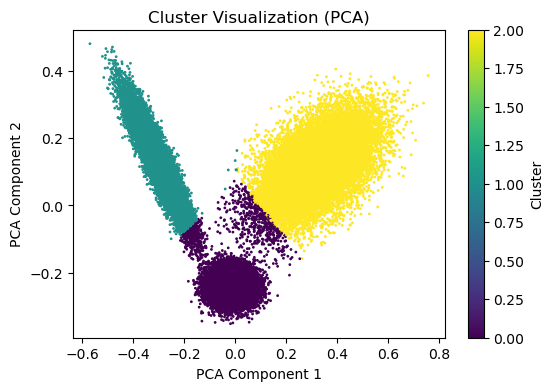

In [259]:
# Evaluating K-Means
evaluate_clusters(df_scaled, df_kmeans, "cluster")

Silhouette = 0.6598
Davies-Bouldin = 0.4675


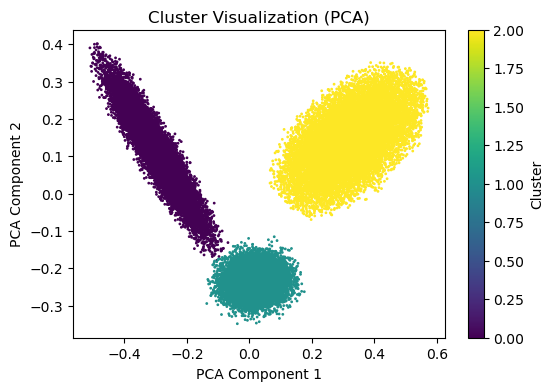

In [260]:
# Evaluating DBSCAN
evaluate_clusters(scaled_db, df_dbscan, "cluster")

Silhouette = 0.6328
Davies-Bouldin = 0.5062


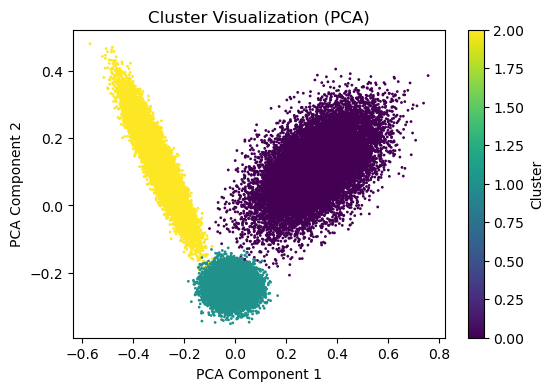

In [261]:
# Evaluating Gaussian Mixture
evaluate_clusters(df_scaled, df_gaussi, "cluster")

Silhouette = 0.6339
Davies-Bouldin = 0.5047


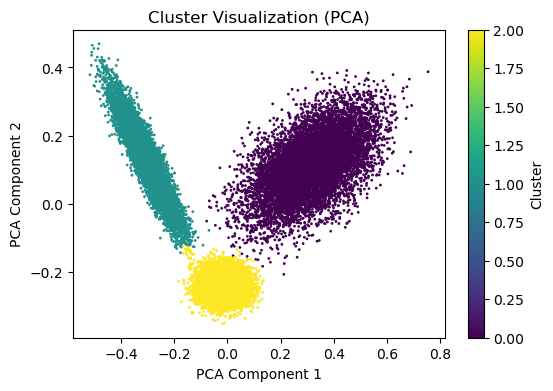

In [263]:
# Evaluating Agglomerative
evaluate_clusters(scaled_ag, df_agglom, "cluster")

These clusters yielded optimal results and will be considered for the next phase: their analysis.